In [9]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from toolbox_02450 import rlr_validate
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Importing data

In [10]:
df = pd.read_csv('data.csv')
df = df.drop('row.names',axis=1)
df['famhist'] = df['famhist'].replace({'Present': 1, 'Absent': 0})
df.head()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,160,12.00,5.73,23.11,1,49,25.30,97.20,52,1
1,144,0.01,4.41,28.61,0,55,28.87,2.06,63,1
2,118,0.08,3.48,32.28,1,52,29.14,3.81,46,0
3,170,7.50,6.41,38.03,1,51,31.99,24.26,58,1
4,134,13.60,3.50,27.78,1,60,25.99,57.34,49,1


# Linear Regression

### 1)
Explain what variable is predicted based on which other variables and what
you hope to accomplish by the regression. Mention your feature transformation
choices such as one-of-K coding. Since we will use regularization momentarily,
apply a feature transformation to your data matrix X such that each column
has mean 0 and standard deviation 1.

In [28]:
target_variable = 'sbp'
features = df.drop(columns=[target_variable]).columns

# Prepare the feature matrix X and the target vector y
X = df[features]
y = df[target_variable].squeeze().values

# We have used one-of-K coding for feature transformation by substituting famhist = present or absent by 1 or 0, respectively

# Feature scaling so that each feature column has mean = 0 and standard deviation = 1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=features)
X_scaled_df.head()

,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,1.823073,0.478412,-0.295503,1.185854,-0.418470,-0.176786,3.277738,0.629336,1.373863
1,-0.790237,-0.159680,0.412140,-0.843274,0.193344,0.671373,-0.612745,1.383115,1.373863
2,-0.774980,-0.609245,0.884332,1.185854,-0.112563,0.735519,-0.541183,0.218184,-0.727875
3,0.842264,0.807126,1.624141,1.185854,-0.214532,1.412621,0.295062,1.040488,1.373863
4,2.171805,-0.599577,0.305351,1.185854,0.703189,-0.012856,1.647775,0.423760,1.373863


### 2)

Introduce a regularization parameter λ as discussed in chapter 14 of the lecture
notes, and estimate the generalization error for different values of λ. Specifically, choose a reasonable range of values of λ (ideally one where the generalization error first drop and then increases), and for each value use K = 10 fold
cross-validation (algorithm 5) to estimate the generalization error.
Include a figure of the estimated generalization error as a function of λ in the
report and briefly discuss the result.

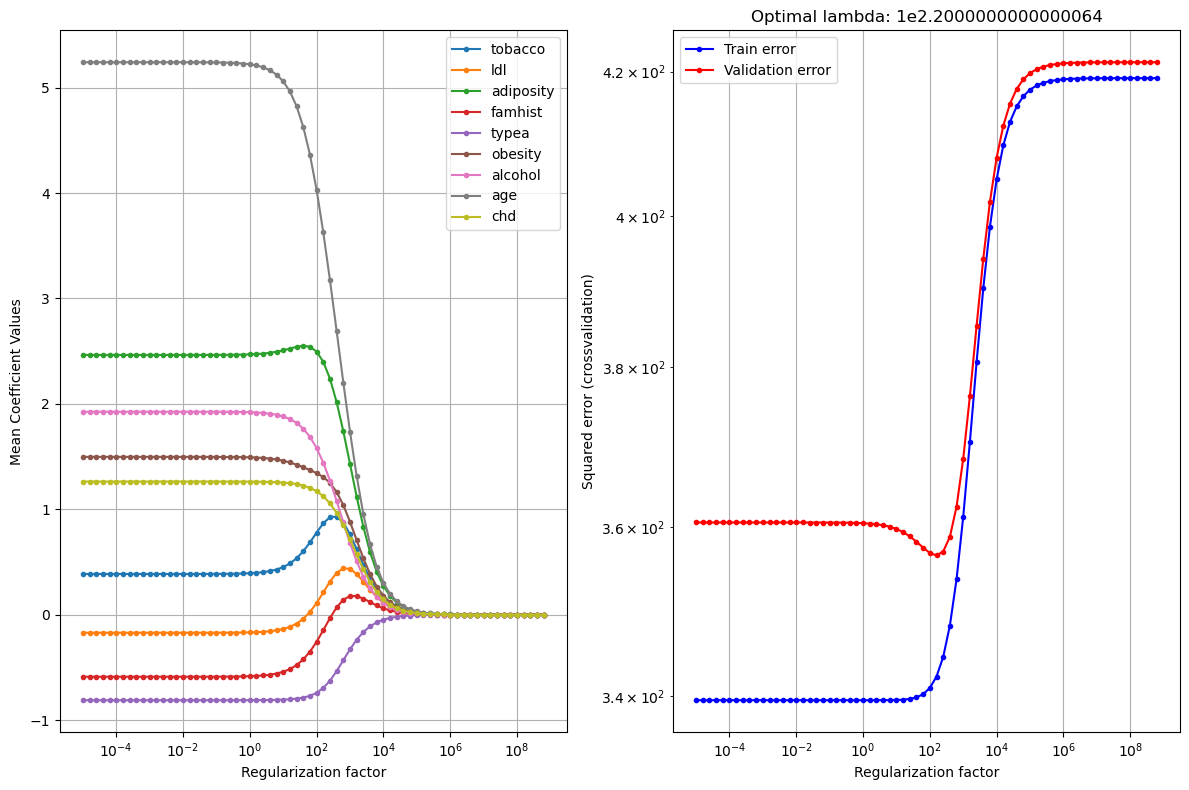

Regularized linear regression:
- Training error: 342.80651309263266
- R^2 train:     0.005671924158529752
Weights:
         Offset          138.33
        tobacco            0.85
            ldl            0.19
      adiposity            2.43
        famhist           -0.18
          typea           -0.71
        obesity            1.31
        alcohol            1.48
            age            3.73
            chd            1.13


In [65]:
X = X_scaled_df

# Attributes names:
attributeNames = X.columns.values.tolist()

# Compute values of N, M
N, M = X.shape

# Add offset attribute
X = np.concatenate((np.ones((X.shape[0], 1)), X), 1)
attributeNames = [u'Offset'] + attributeNames
M = M + 1

K = 10

# --------------------Regression Part A ------------------#
# Values of lambda
lambdas = np.power(10.,np.arange(-5,9,0.2))

# Initialize variables
Error_train = np.empty((1,1))
Error_test = np.empty((1,1))
Error_train_rlr = np.empty((1,1))
Error_test_rlr = np.empty((1,1))
Error_train_nofeatures = np.empty((1,1))
Error_test_nofeatures = np.empty((1,1))
w_rlr = np.empty((M,1))
mu = np.empty((1, M-1))
sigma = np.empty((1, M-1))
w_noreg = np.empty((M,1))

opt_val_err, opt_lambda, mean_w_vs_lambda, train_err_vs_lambda, test_err_vs_lambda = rlr_validate(X, y, lambdas, K)

Xty = X.T @ y
XtX = X.T @ X

# Estimate weights for the optimal value of lambda, on entire training set
lambdaI = opt_lambda * np.eye(M)
lambdaI[0,0] = 0 # Do no regularize the bias term
w_rlr[:,0] = np.linalg.solve(XtX+lambdaI,Xty).squeeze()
# Compute mean squared error with regularization with optimal lambda
Error_train_rlr[0] = np.square(y-X @ w_rlr[:,0]).sum(axis=0)/y.shape[0]

# Estimate weights for unregularized linear regression, on entire training set
w_noreg[:,0] = np.linalg.solve(XtX,Xty).squeeze()
# Compute mean squared error without regularization
Error_train[0] = np.square(y-X @ w_noreg[:,0]).sum(axis=0)/y.shape[0]

# Display the results
plt.figure(1, figsize=(12,8))
plt.subplot(1,2,1)
plt.semilogx(lambdas,mean_w_vs_lambda.T[:,1:],'.-') # Don't plot the bias term
plt.xlabel('Regularization factor')
plt.ylabel('Mean Coefficient Values')
plt.legend(attributeNames[1:], loc='best')
plt.grid()

plt.subplot(1,2,2)
plt.title('Optimal lambda: 1e{0}'.format(np.log10(opt_lambda)))
plt.loglog(lambdas,train_err_vs_lambda.T,'b.-',lambdas,test_err_vs_lambda.T,'r.-')
plt.xlabel('Regularization factor')
plt.ylabel('Squared error (crossvalidation)')
plt.legend(['Train error','Validation error'])
plt.grid()

plt.tight_layout()
plt.show()

# Display results
print('Regularized linear regression:')
print('- Training error: {0}'.format(Error_train_rlr.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train_rlr.sum())/Error_train_nofeatures.sum()))

print('Weights:')
for m in range(M):
    print('{:>15} {:>15}'.format(attributeNames[m], np.round(w_rlr[m,0],2)))
    